## Solving the Quantum Linear Systems Problem (QLSP) using AQC 


### **Overview**


**Adiabatic Quantum Computing (AQC)** leverages the adiabatic theorem to solve computational problems by gradually evolving a quantum system from an initial ground state to the ground state of a problem-specific Hamiltonian (see our AQC tutorial - ADD LINK). This tutorial focuses on applying the AQC approach to solve the **Quantum Linear Systems Problem (QLSP)**, a cornerstone problem in quantum computing with significant applications in fields like machine learning, physics, and optimization.

Specifically, we aim to demonstrate how AQC can be utilized to approximate the solution to the QLSP [[1](#QLSP)]. This problem involves finding a quantum state that corresponds to the solution of a linear system of equations. The tutorial provides a structured overview of the QLSP, its mathematical formulation, and the steps needed to transform it into an eigenvalue problem, laying the foundation for solving it within the AQC framework (based on [[1](#QLSP)]).



---


### **1. Problem Statement**

Given a Hermitian positive-definite matrix $A$ and a vector $|b\rangle$, the goal is to approximate 
$|x\rangle$, the solution to the linear system $A|x\rangle=|b\rangle$, as a quantum state.


We are given:
- **Matrix** $A \in \mathbb{C}^{N \times N}$, an invertible Hermitian and positive-definite matrix with condition number $\kappa$ and $\|A\|_2 = 1$.
- **Vector** $|b\rangle \in \mathbb{C}^N$, a normalized vector.
- **Target Error** $\epsilon$, specifying the desired accuracy.

The goal is to prepare a quantum state $|x_a\rangle$, which is an $\epsilon$-approximation of the normalized solution $|x\rangle = A^{-1}|b\rangle / \|A^{-1}|b\rangle\|_2$. The approximation satisfies:

$$
\| |x_a\rangle \langle x_a| - |x\rangle \langle x| \|_2 \leq \epsilon.
$$

---

### **2. Transformation into AQC**

The QLSP is converted into an equivalent eigenvalue problem to leverage quantum computation. This involves the following steps:

#### **2.1 Null Space of $H_0$**
Define:

$$
H_0 = \sigma_x \otimes Q_b = 
\begin{bmatrix}
0 & Q_b \\
Q_b & 0
\end{bmatrix},
$$

where $Q_b = I_N - |b\rangle \langle b|$ is a projection operator orthogonal to $|b\rangle$.

Key properties:
- $H_0$ is Hermitian.
- The null space of $H_0$: $\text{Null}(H_0) = \text{span}(|b\rangle, |\bar{b}\rangle)$, where 

$$
|b\rangle = |0, b\rangle = \begin{bmatrix} b \\ 0 \end{bmatrix}, \quad 
|\bar{b}\rangle = |1, b\rangle = \begin{bmatrix} 0 \\ b \end{bmatrix}.
$$

#### **2.2 Constructing $H_1$**
Define:

$$
H_1 = \sigma_+ \otimes (AQ_b) + \sigma_- \otimes (Q_bA) =
\begin{bmatrix}
0 & AQ_b \\
Q_bA & 0
\end{bmatrix},
$$

where $\sigma_\pm = \frac{1}{2}(\sigma_x \pm i\sigma_y)$.

Key properties:
- If $A|x\rangle \propto |b\rangle$, then $Q_bA|x\rangle = Q_b|b\rangle = 0$.
- Null space of $H_1$: $\text{Null}(H_1) = \text{span}(|x\rangle, |\bar{b}\rangle)$.

#### **2.3 Spectral Gap**
- $Q_b$ is a projection operator, and the spectral gap of $H_0$ is $1$.
- For $H_1$, the gap between $0$ and the rest of the eigenvalues is bounded below by $1/\kappa$.

#### **2.4 Adiabatic Interpolation**
Construct an interpolation Hamiltonian:

$$
H(f(s)) = (1 - f(s))H_0 + f(s)H_1, \quad 0 \leq s \leq 1,
$$

where $f(s)$ is a monotonic function mapping $[0, 1] \to [0, 1]$.

---

### **3. AQC Approach**
The adiabatic quantum algorithm prepares the zero-energy state $|x\rangle$ of $H_1$ as follows:
1. Initialize in the ground state of $H_0$, i.e., $|b\rangle$.
2. Slowly evolve the system by varying $f(s)$ from $f(0) = 0$ to $f(1) = 1$.
3. At the end of the evolution, the system will approximate $|x\rangle$, the solution of the QLSP.

---

### **4. Goals**
- **Set up a QLSP example:** Derive $H_0$, $H_1$.
- **Quantum Circuit Design:** Implement Hamiltonian simulation for $H(f(s))$.
- **Evaluate results:** Compare quantum simulation results with the numeric calculation.

---


Let’s begin with the mathematical setup and proceed to implementation!


### **Setting up a QLSP example where A is a 4x4 matrix:**

For simplicity, we first assume A is Hermitian and positive definite


In [1]:
import numpy as np

# Define matrix A and vector b
A = np.array([[4, 1, 2, 0], 
              [1, 3, 0, 1], 
              [2, 0, 3, 1], 
              [0, 1, 1, 2]])
b = np.array([12, 10, 17, 26])


#### Setting up the QLSP:

In [2]:
from classiq import *

def setup_QLSP(A,b):
    #Normalize A
    norm_A = np.linalg.norm(A, 'fro')
    A_normalized = A / norm_A

    # Normalize vector b
    b_normalized = b / np.linalg.norm(b)
    
    # Create the outer product of b
    outer_product_b = np.outer(b_normalized, b_normalized)
    
    # Define the identity matrix I with the same size as b
    identity_matrix = np.eye(len(b))
    
    # Compute Qb = I - outer_product_b
    Qb = identity_matrix - outer_product_b
    
    # Define the Pauli-X (σx) and Pauli-Y (σy) matrices
    pauli_x = np.array([[0, 1], 
                        [1, 0]])
    
    pauli_y = np.array([[0, -1j], 
                        [1j, 0]])
    
    # Define Pauli plus and minus operators
    pauli_plus = 0.5 * (pauli_x + 1j * pauli_y)
    pauli_minus = 0.5 * (pauli_x - 1j * pauli_y)
    
    # Compute the tensor product of Pauli-X and Qb
    H0 = np.kron(pauli_x, Qb)
    
    # Compute A*Qb and Qb*A
    A_Qb = np.dot(A, Qb)
    Qb_A = np.dot(Qb, A)
    
    # Compute the tensor products
    tensor_plus = np.kron(pauli_plus, A_Qb)
    tensor_minus = np.kron(pauli_minus, Qb_A)
    
    # Define Hf as the sum of the two tensor products
    Hf = tensor_plus + tensor_minus

    HO_HAMILTONIAN = matrix_to_hamiltonian(H0)
    Hf_HAMILTONIAN = matrix_to_hamiltonian(Hf)

    return H0, Hf, HO_HAMILTONIAN , Hf_HAMILTONIAN, A_normalized, b_normalized


#Setup 

H0, Hf, HO_HAMILTONIAN , Hf_HAMILTONIAN, A_normalized, b_normalized = setup_QLSP(A,b)
TOTAL_EVOLUTION_TIME = 1
NUM_STEPS = 100

# Define the time-dependent Interpolated Hamiltonian, where T is the total evolution time
def hamiltonian_t(H0, Hf, t, T):
    return (1 - t/T) * H0 + (t/T) * Hf

In [3]:
import matplotlib.pyplot as plt

def plot_eigenvalues_evolution():
    time_steps = np.linspace(0, TOTAL_EVOLUTION_TIME, NUM_STEPS)  # Discrete time steps

    # Store eigenvalues at each time step
    eigenvalues = []
    
    # Calculate eigenvalues across all time steps
    for t in time_steps:
        H_t = hamiltonian_t(H0, Hf, t, TOTAL_EVOLUTION_TIME)
        eigvals = np.linalg.eigvalsh(H_t)  # Sorted real eigenvalues
        eigenvalues.append(eigvals)
    
    # Convert eigenvalues list to a NumPy array for easier manipulation
    eigenvalues = np.array(eigenvalues)
    
    # Add small offsets to separate close eigenvalues visually
    offsets = np.linspace(-0.05, 0.05, eigenvalues.shape[1])  # Small offsets for each eigenvalue line
    
    # Plot the eigenvalues across time steps
    plt.figure(figsize=(10, 6))
    for i in range(eigenvalues.shape[1]):
        plt.plot(time_steps, eigenvalues[:, i] + offsets[i], label=f"Eigenvalue {i+1}")
    
    # Highlight degenerate eigenvalues (if any)
    for step_idx, t in enumerate(time_steps):
        unique_vals, counts = np.unique(eigenvalues[step_idx], return_counts=True)
        
    
    # Customize the plot
    plt.xlabel("Time (t)", fontsize=12)
    plt.ylabel("Eigenvalues", fontsize=12)
    plt.title("Eigenvalues Evolution Across Time Steps with Separation", fontsize=14)
    plt.grid()
    
    # Move the legend to the side
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    
    # Show the plot
    plt.show()


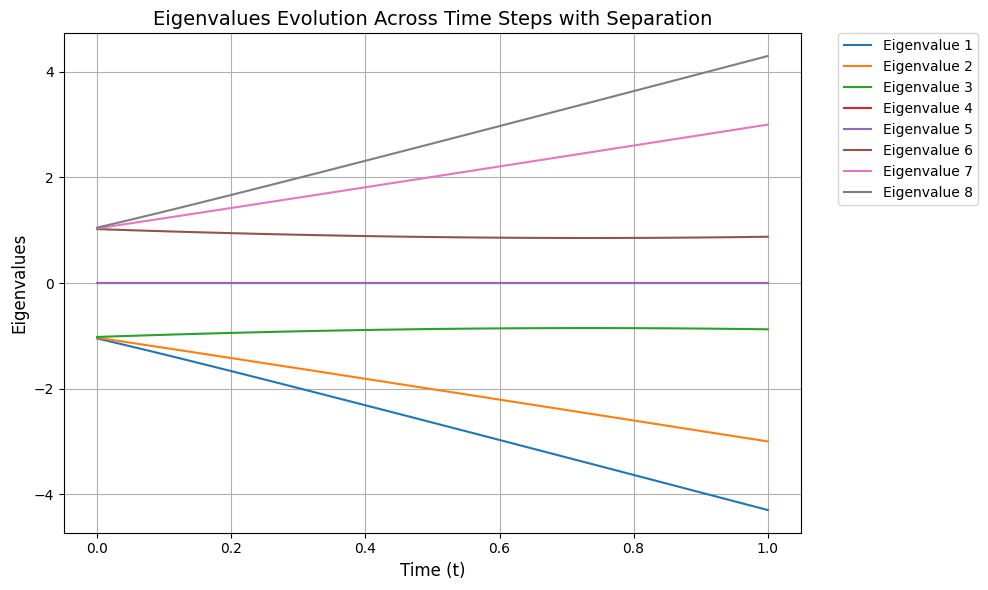

In [4]:
plot_eigenvalues_evolution()

### **Quantum AQC Implementation:**


Since $$ |\psi_T(s) \rangle = \mathcal{T}\exp \left( -iT \int_0^s H(f(s')) ds' \right) |\psi_T(0) \rangle \ , $$ where $\mathcal{T}$ is the time-ordering operator, it is sufficient to implement an efficient time-dependent Hamiltonian simulation of $H(f(s))$.

One straightforward approach to achieve this is by using the Trotter splitting method. The lowest order approximation takes the form:

$$
\mathcal{T}\exp \left( -iT \int_0^s H(f(s')) ds' \right) \approx \prod_{m=1}^M \exp \left( -iTh H(f(s_m)) \right)
$$

which can further be approximated as:

$$
\prod_{m=1}^M \exp \left( -iTh(1 - f(s_m)) H_0 \right) \exp \left( -iTh f(s_m) H_1 \right)
$$

where $$h = s/M,  s_m = mh.$$


Using the Classiq platform, we implement the adiabatic path with Suzuki-Trotter decomposition for Hamiltonian exponentiation.


*We will use the "vanilla AQC" linear scheduling function $f(s(t)) = s(t) = t / T$*




**Building a Quantum model:**

In our model $T$ is represented by the `TOTAL_EVOLUTION_TIME` and $M$ is represented as `NUM_STEPS`.
Therefore $h$ is `delta_t` and $s_m$ is `t`.

In [5]:
import numpy as np

def calculate_M(N, T, epsilon):
    """
    Calculate M = O(poly(log(N)) * T^2 / epsilon)
    
    Parameters:
        N (int): System size
        T (float): Total evolution time
        epsilon (float): Precision parameter

    Returns:
        float: Computed value of M
    """
    # Compute log(N)
    log_N = np.log(N)  # Natural log

    # Assume poly(log(N)) = (log(N))^2
    poly_log_N = log_N ** 2

    # Compute T^2 / epsilon
    time_precision_term = (T ** 2) / epsilon

    # Calculate M
    M = poly_log_N * time_precision_term
    return M

# Given parameters
N = 4
T = 1
epsilon = 0.01

# Calculate M
M = calculate_M(N, T, epsilon)

# Print the result
print(f"For N={N}, T={T}, and epsilon={epsilon}, the calculated M is approximately: {M:.2f}")

For N=4, T=1, and epsilon=0.01, the calculated M is approximately: 192.18


In [6]:
import numpy as np

def calculate_condition_number(matrix):
    """
    Calculate the condition number of a matrix using the 2-norm.

    Parameters:
        matrix (np.ndarray): The input matrix

    Returns:
        float: The condition number of the matrix
    """
    singular_values = np.linalg.svd(matrix, compute_uv=False)
    max_singular = max(singular_values)
    min_singular = min(singular_values)

    # Avoid division by zero for singular matrices
    if min_singular == 0:
        return np.inf

    condition_number = max_singular / min_singular
    return condition_number

def calculate_sparsity(matrix):
    """
    Calculate the sparsity of a matrix (d), defined as the maximum number of nonzero elements in any row.

    Parameters:
        matrix (np.ndarray): The input matrix

    Returns:
        int: The sparsity of the matrix
    """
    sparsity = max(np.count_nonzero(row) for row in matrix)
    return sparsity

# Define matrix A
A = np.array([[4, 1, 2, 0], 
              [1, 3, 0, 1], 
              [2, 0, 3, 1], 
              [0, 1, 1, 2]])

# Calculate and print the condition number
k = calculate_condition_number(A)
print(f"The condition number of matrix A is: {k:.2f}")

# Calculate and print the sparsity
d = calculate_sparsity(A)
print(f"The sparsity of matrix A is: {d}")


The condition number of matrix A is: 14.47
The sparsity of matrix A is: 3


In [7]:
@qfunc(generative=True)
def adiabatic_evolution_qfunc(evolution_time: CInt, num_steps: CInt, qba: QArray[QBit]):
    # Time step for each increment
    delta_t = evolution_time / num_steps
    for step in range(num_steps):
        t = step * delta_t
        suzuki_trotter(
        HO_HAMILTONIAN,
        evolution_coefficient=(1 - t/evolution_time),
        order=1,
        repetitions=1,
        qbv=qba,
        )
        suzuki_trotter(
        Hf_HAMILTONIAN,
        evolution_coefficient=(t/evolution_time),
        order=1,
        repetitions=10,
        qbv=qba,
        )
      


In [8]:
@qfunc
def main(qba: Output[QArray[QBit]]):
    prepare_state(probabilities= (np.abs(np.kron(np.array([1,0]),b_normalized ))**2).tolist(), bound=0.01, out=qba)
    adiabatic_evolution_qfunc(TOTAL_EVOLUTION_TIME, NUM_STEPS, qba)


qmod = create_model(main)






**Synthesize the model into a Quantum Program, verify it and execute it on a state vector simulator:** 

In [10]:
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)
from classiq.qmod.symbolic import pi



execution_preferences = ExecutionPreferences(
    num_shots=1,
    backend_preferences=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    ),
)
qmod = set_execution_preferences(qmod, execution_preferences)


qprog = synthesize(qmod)
write_qmod(qmod, "solving_qlsp_with_aqc")
show(qprog)

result = execute(qprog).result_value()
result_state_vector = result.state_vector

Opening: https://platform.classiq.io/circuit/69b575db-3aee-42a0-a326-3e3a10b5f49f?version=0.60.1


### **Evaluate results:**

In [11]:
def plot_state_probabilities(title, x , color='b'):
    # Ensure x is a numpy array and normalized
    x = np.array(x)
    
    # Calculate probabilities
    probabilities = np.abs(x) ** 2
    
    # Create labels for the states
    labels = [f'|{i}>' for i in range(len(x))]
    
    # Plot the probabilities
    plt.bar(labels, probabilities, color=color, alpha=0.7)
    plt.xlabel('States')
    plt.ylabel('Probabilities')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.show()

def phase_difference(v1, v2):
    # Ensure vectors are complex
    v1 = np.array(v1, dtype=np.complex128)
    v2 = np.array(v2, dtype=np.complex128)
    
    # Compute the inner product and find its angle (phase difference)
    inner_product = np.vdot(v1, v2)  # Computes conjugate transpose of v1 * v2
    phase_diff = np.angle(inner_product)  # Angle of the inner product in radians
    
    return phase_diff

def compare_states(state1, state1_label, state2, state1_labe2, color1 ='gold',color2='b'):
    # Plot a histogram of each state probabilities
    plot_state_probabilities(state1_label ,state1, color1)
    plot_state_probabilities(state1_labe2,state2, color2)
    
    # Check the overlap between states
    overlap = np.abs(np.vdot(state1, state2))**2
    print(f"Similarity of results: {overlap:.4f}")
    # Calculate phase difference
    phase_diff = phase_difference(state1, state2)
    print(f"Phase difference: {np.degrees(phase_diff)} degrees")




Solution vector x:
[ 0.32300564 -0.23491319 -0.22423532  0.88893288]
State vector:
[ 0.17569561+0.2504778j  -0.1220673 -0.17402341j -0.12169957-0.17349916j
  0.51216533+0.7301608j   0.07062183-0.04953711j  0.00675191-0.00473607j
 -0.04419679+0.03100148j  0.08357987-0.05862642j]


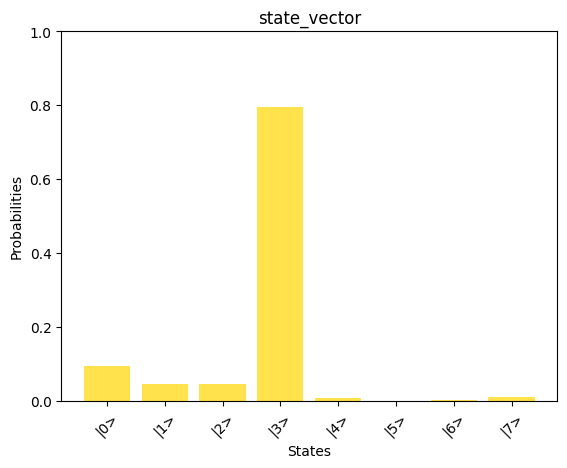

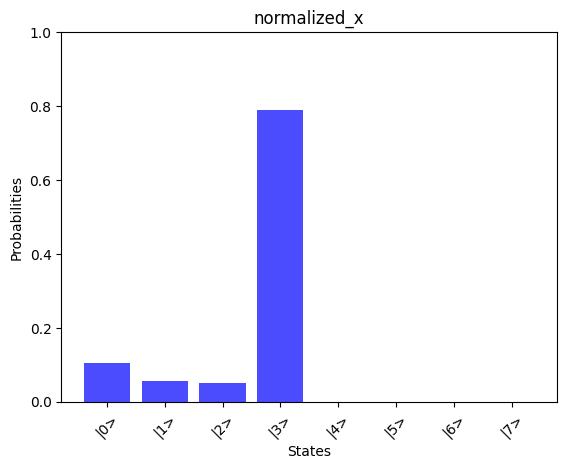

Similarity of results: 0.9783
Phase difference: -54.952573605591034 degrees


In [12]:
# Print the solution vector x
# Use np.linalg.solve() to find x
x = np.linalg.solve(A_normalized, b_normalized)
print("Solution vector x:")
normalized_x = x/ np.linalg.norm(x)
print(normalized_x)

# Convert dictionary values to complex numbers
print("State vector:")
state_vector = np.array([complex(value) for value in result_state_vector.values()])
print(state_vector)

compare_states(state_vector,'state_vector', np.kron(np.array([1,0]),normalized_x ),'normalized_x')

***By comparing the quantum-computed results with the mathematically expected solution, we observe a good alignment - showcasing the potential of the AQC approach for solving linear problems***

<a id='QLSP'>[1]</a>: [An, D. and Lin, L. “Quantum Linear System Solver Based on Time-Optimal Adiabatic Quantum Com- puting and Quantum Approximate Optimization Algorithm.” ACM Trans. Quantum Comput. 3 (2022). arXiv:1909.05500.](https://arxiv.org/abs/1909.05500).


